<div class="alert alert-danger">

**Read the `Instructions` and `BayesNet Introduction` notebooks** before you start working on this problem set! They contain instructions on how to create the submission package and a detailed description of the provided classes (*BayesNet* and *Variable*).
    
</div>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from bayesian_network import BayesNet

# Rejection Sampling


We will implement the rejection sampling algorithm in this notebook and use it to approximate probabilistic query $P(A \mid D, E)$ for the Bayesian Network given below. In Rejection Sampling, one samples from the full joint distribution and throws away ('rejects') all samples that do not correspond to the evidence.

To make your solutions testable, we ask you to implement two functions, namely:
- `sample_forward`, and
- `rejection_sampling`.

`sample_forward` returns a set of samples from the full joint distribution $P(\mathcal{X})$.

`rejection_sampling` uses *sample_forward*, throws away all random events with mismatching evidence $\mathbf{E}$, and estimates the distribution of query variable $X$. In other words, it computes an approximation of $P(X \mid \mathbf{E}=e)$. For simplicity, we will only consider probabilistic queries with one query variable $X$.

### Forward Sampling 
<div class="alert alert-warning">
Implement the <i>sample_forward</i> function, which samples from the full joint distribution of a Bayesian network $\mathcal{B}$. (4 points)
</div>

The `sample_forward` function must return one object:
- samples from the Bayesian network $\mathcal{B}$ of type `np.ndarray`, with shape `(sample_size, len(bayes_net))`


**Hints**: 
- Iterating over the *BayesNet* object returns the *Variable* objects in topological ordering. The 1-D probability distribution of variable $X$ given its parents $\mathit{pa}(X)$, $P(X \mid \mathit{pa}(X))$, can be obtained by passing the (possibly incomplete) random event to the variable, i.e., `variable(samples[i])`.
- We will also need a function that samples from a discrete 1-D probability distribution. For this purpose, use the `sample_categorical()` function from the Instructions notebook, which takes a 1-D NumPy array representing a probability distribution and draws a sample from it:

In [2]:
from utils import sample_categorical
help(sample_categorical)

Help on function sample_categorical in module utils:

sample_categorical(dist: numpy.ndarray) -> numpy.int64
    Draws a single sample from a categorical distribution.
    :param dist: NumPy array listing the probability of each outcome.
    :returns: Index of the sampled element.



In [3]:
def sample_forward(bayes_net: BayesNet, sample_size: int) -> np.ndarray:
    '''
    Samples from the full joint distribution.
    :param bayes_net: A Bayesian network of type BayesNet.
    :param sample_size: The number of samples to draw from the Bayesian network.
    :returns: A NumPy array of type np.int64 with shape (sample_size, len(bayes_net))
              containing samples from the Bayesian network
    '''
    # array holding the samples
    samples = np.empty((sample_size, len(bayes_net)), np.int64)
    # YOUR CODE HERE
    for i in range(sample_size):
        for variable in bayes_net:
            distribution = variable(samples[i]) # gives P(X_I | Parent(X_i))
            samples[i][variable.id] = sample_categorical(distribution)
            
    return samples

In [4]:
# sanity checks
bayes_net = BayesNet((np.array([0.5, 0.5]), [0]))

samples = sample_forward(bayes_net, 3)

assert type(samples) == np.ndarray, f'\nWrong output type!\nExpected: np.ndarray\nGiven:\t  {type(samples)}'
assert samples.shape == (3, 1), f'\nWrong output shape!\nExpected: (3, 1)\nGiven:\t  {samples.shape}'
assert samples.dtype == np.int64, f'\nWrong numpy array data type!\nExpected: np.int64\nGiven:\t  {samples.dtype}'

### Rejection Sampling 
<div class="alert alert-warning">
    Implement the <i>rejection_sampling</i> function, which estimates the probability distribution over the query variable $X$ given evidence  $\mathbf{E}=\mathbf{e}$, i.e. $P(X \mid \mathbf{E}=\mathbf{e})$. Use the <i>sample_forward</i> function implemented in the previous step to draw random events from $P(\mathcal{X})$. (4 points)
</div>

The `rejection_sampling` function must return one object:
-  The 1-D probability distribution over variable $X$ of type `np.ndarray` with shape `(bayes_net[query_variable].num_values,)`. If the sample from the FJD does not contain any random events with matching evidence, return a NumPy array with the same shape as $P(X \mid \mathbf{E}=\mathbf{e})$ containing only values `np.nan`, i.e. `np.full(bayes_net[query_variable].num_values, np.nan)`.

**Hints**: 
- Use `np.bincount` to count the number of occurrences of each value. It even supports a minimum number of bins -- check out its  ([documentation](https://numpy.org/doc/stable/reference/generated/numpy.bincount.html))!
- For simplicity, we will only consider probabilistic queries with one query variable $X$.

In [5]:
def rejection_sampling(bayes_net: BayesNet, query_variable: int, evidence: dict={}, sample_size: int=100) -> np.ndarray:
    '''
    Estimates the distribution of the query variale given the value of the evidence variables.
    :param bayes_net: A Bayesian network of type BayesNet.
    :param query_variable: Id of the query variable (int).
    :param evidence: A dictionary of evidence variables (keys: int) and their correponding values (values: int).
    :param sample_size: The number of samples to use for the estimation.
    :returns: A NumPy array of type np.float64 representing the conditional distribution of the query variable given evidence, or a NumPy array of the same shape but with all values set to np.nan if no sample with matching evidence is found. 
    '''
    
    # forward sample...
    samples = sample_forward(bayes_net, sample_size)
    
    # Filter and reject phase
    for key, value in evidence.items():    
        samples = samples[samples[:, key] == value]

    D_est = len(samples)
    if D_est == 0:
        return np.full(bayes_net[query_variable].num_values, np.nan)
    
    # Estimation phase
    K = np.bincount(samples[:, query_variable], minlength=bayes_net[query_variable].num_values)
    
    # Return sampled distribution    
    return K / D_est


In [6]:
# sanity checks
bayes_net = BayesNet((np.array([0.25, 0.25, 0.5]), [0]))

np.random.seed(0)
distribution = rejection_sampling(bayes_net, 0, {0:0}, 3)
assert distribution.shape == (3,), f'\nWrong output shape!\nExpected: (3,)\nGiven:\t  {distribution.shape}'
assert np.all(np.isnan(distribution)), f'Wrong distribution\nExpected: {np.full(3,np.nan)}\nGot: {distribution}\n'\
                                        'No matching evidence drawn in 3 samples for random seed 0.'

distribution = rejection_sampling(bayes_net, 0, {}, 1000)
assert type(distribution) == np.ndarray, f'\nWrong output type!\nExpected: np.ndarray\nGiven:\t  {type(distribution)}'
assert distribution.shape == (3,), f'\nWrong output shape!\nExpected: (3,)\nGiven:\t  {distribution.shape}'
assert distribution.dtype == np.float64, f'\nWrong numpy array data type!\nExpected: np.float64\nGiven:\t  {distribution.dtype}'

## Example


Now that we can approximate arbitrary probabilistic queries let us compare an approximation's accuracy to an exact solution.

Consider the following Bayesian Network (all variables are binary):

<img width='30%' src='bn.svg'>

The conditional probability tables are given as:

<table style="float: left;margin:5px;"><tr><th>P(A)</th><th>$a_0$<br></th><th>$a_1$</th></tr><tr><td>-</td><td>0.2</td><td>0.8</td></tr></table>

<table style="float: left;margin:5px;"><tr><th>P(C)</th><th>$c_0$<br></th><th>$c_1$</th></tr><tr><td>-</td><td>0.9</td><td>0.1</td></tr></table>

<table style="float: left;margin:5px;"><tr><th>P(B | A)</th><th>$a_0$<br></th><th>$a_1$</th></tr><tr><td>$b_0$</td><td>0.9</td><td>0.2</td></tr><tr><td>$b_1$</td><td>0.1</td><td>0.8</td></tr></table>


<table style="float: left;margin:5px;"><tr><th rowspan="2">P(D | B, C)</th><th colspan="2">$b_0$<br></th><th colspan="2">$b_1$</th></tr><tr><td>$c_0$</td><td>$c_1$</td><td>$c_0$</td><td>$c_1$</td></tr><tr><td>$d_0$<br></td><td>0.1</td><td>0.2</td><td>0.99</td><td>0.8</td></tr><tr><td>$d_1$</td><td>0.9</td><td>0.8</td><td>0.01</td><td>0.2</td></tr></table>

<table style="float: left;margin:5px;"><tr><th>P(E | C)</th><th>$c_0$</th><th>$c_1$</th></tr><tr><td>$e_0$</td><td>0.7</td><td>0.4</td></tr><tr><td>$e_1$</td><td>0.3</td><td>0.6</td></tr></table>

First, let us store these tables as global NumPy arrays and create the BayesNet object:

In [7]:
_A_, _B_, _C_, _D_, _E_ = 0, 1, 2, 3, 4

A = np.array([0.2, 0.8])
B_A = np.array([[0.9, 0.2], [0.1, 0.8]])
C = np.array([0.9, 0.1])
D_BC = np.array([[[0.1, 0.2], [0.99, 0.8]], [[0.9, 0.8], [0.01, 0.2]]])
E_C = np.array([[0.7, 0.4], [0.3, 0.6]])
              
bayes_net = BayesNet(
    (A, [_A_]),
    (B_A, [_B_, _A_]),
    (C, [_C_]),
    (D_BC, [_D_, _B_, _C_]),
    (E_C, [_E_, _C_])
)

### Exact Computation 
<div class="alert alert-warning">
Compute $P(A \mid D, E)$ exactly (up to floating point precision). (1 point)
</div>

Feel free to do this in a very inefficient manner, e.g., by first computing the joint probability distribution and then normalizing by the evidence.

**Hint**: Have a look into the BayesNet Introduction notebook again if you are unsure how to compute the full joint distribution.

In [8]:
A_DE = None

#calc the full joint distribution
ABCDE = 1
for variable in bayes_net:
    ABCDE = ABCDE * variable.pdt

ADE = ABCDE.sum(axis=(1,2))
DE = ADE.sum(axis=(0))
A_DE = ADE/DE

In [9]:
# sanity checks
assert A_DE is not None
assert A_DE.shape == (2, 2, 2)
assert np.all(np.isclose(A_DE.sum(axis=0), 1)), 'Expected well formed distributions with columns summing to 1.'

### Comparison

Run the following code cell to plot the average [Kullback-Leibler divergence](https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence) between the exact distribution $P(A \mid D, E)$ and the approximations computed with rejection sampling. Different lines represent different value assignments to the evidence variables $D$ and $E$.

**Hint**: The computation of the approximations might take a while...

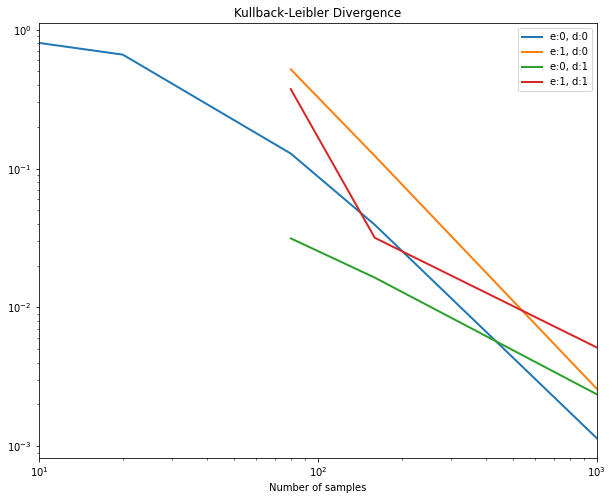

In [10]:
from utils import approx_error

np.random.seed(0)
errs = {}
sample_counts = np.array([10, 20, 80, 160, 1000])

# compute approximation error
for d, e in zip([0, 0, 1, 1], [0, 1, 0, 1]):
    errs[(d, e)] = approx_error(
        bayes_net,
        rejection_sampling,  
        A_DE[:, d, e],
        _A_,
        {_D_:d, _E_:e}, 
        sample_counts,
        n_runs=100
    )

# plot
plt.figure(figsize=(10, 8))
plt.title('Kullback-Leibler Divergence')
for d, e in zip([0, 0, 1, 1], [0, 1, 0, 1]):
    plt.plot(sample_counts, errs[(d, e)], label=f'e:{e}, d:{d}', lw=2)
    
plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.xlim(sample_counts.min(), sample_counts.max())
plt.xlabel('Number of samples')
plt.show()

<div class="alert alert-warning">
Answer the following question with <b>one short</b> $\LaTeX$ statement! (1 point)
</div>

Given the previous example: What distribution is used to sample a value for variable $D$ in forward sampling? (Just name the distribution, do not give the numbers.)

P(D | B,C)

(Categorical Distribution)

<div class="alert alert-warning">
Answer the following question in <b>one sentence</b>! (1 point)
</div>

Have a look at the average approximation errors when sampling $10^3$ samples with forward sampling. Why is the approximation error of $P(A \mid e=1, d=1)$ higher than the approximation error of $P(A \mid e=0, d=0)$?

Looking at the conditional probability tables, it is more likely to get d=0, e=0 and therefore the real value can be better aproximated than for the lower probable p=1, e=1 as more samples will be rejected for the latter.

<div class="alert alert-warning">
Store the answer to the following question into the provided result variable! (1 point)
</div>

Assume $d=1$ and $e=0$. On average, how many of the random events sampled from $P(\mathcal{X})$ will be accepted by the rejection sampling algorithm (i.e., not rejected)? Give the fraction of samples accepted, e.g. 0.5, if every 2nd sample contains the correct evidence.

In [17]:
result = None
# YOUR CODE HERE
result = DE[1][0]

In [18]:
assert result is not None